(256, 12, 12, 2)


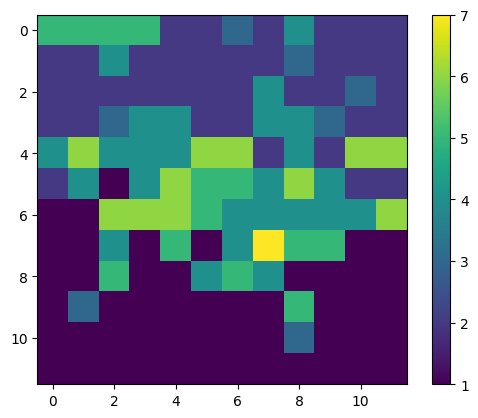

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

train_dir = "/home/zl310/cs585_project/vmoe/expert_assign_train_ImageNetData"

files = os.listdir(train_dir)

load1 = np.load(os.path.join(train_dir, files[-565]))
print(load1.shape)
plt.imshow(load1[0, :, :, 0])
plt.colorbar()

In [2]:
import jax
from jax import numpy as jnp

import tensorflow as tf

from vmoe.nn import models
from vmoe.data import input_pipeline
from vmoe.checkpoints import partitioned

from vmoe.configs.vmoe_paper.vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012 import get_config, IMAGE_SIZE, BATCH_SIZE


model_config = get_config()
model_cls = getattr(models, model_config.model.name)
model = model_cls(deterministic=True, **model_config.model)

# using this model: 'gs://vmoe_checkpoints/vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012'
# checkpoint_prefix = 'vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012'
# checkpoint = partitioned.restore_checkpoint(prefix=checkpoint_prefix, tree=None)

dataset_config_test = model_config.dataset.test
dataset_test = input_pipeline.get_dataset(
    variant='test',
    name=dataset_config_test.name, 
    split=dataset_config_test.split, 
    batch_size=dataset_config_test.batch_size, 
    process=dataset_config_test.process,
    shuffle_seed=20
)

2024-04-10 12:23:38.010439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/zl310/anaconda3/envs/cs585_tf_google/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
i = 0
for batch in dataset_test:
    mask = batch['__valid__']
    true_lbl = np.argmax(batch['labels'], axis=1)
    print(true_lbl[20:50])
    if i > 10:
        break
    i += 1
    

[135 324 582 222 717  18 601 179 368 707 671 365 370 268 383 355 310 809
 853  15 534 906 908 234 189 986 460 646 224 644]
[993 248 701 987   4 915 413 921 885 123 404 254 704 875 460 449 801 948
 827 915 482 656  86 217 395  78 951 472 909 601]
[ 47 695 842 819  27 707 144 187 167 768 101 675 289 163 363 660 465 993
  90 104 645 539 230 444 717 427 985 310 341  38]
[730 573 195 897  26 172 633 346 830 986 355 475 134 321 906 254  68 740
 699 785 479 247 643 882 664 393 228 369  82 386]
[975 853 161 319  69 398 344 204  98 845  35 160 730 785 434 236  29 571
 805 336 566 871 491 526 730 279 178 724 757 928]
[327 861 937 894  44 779 512  38 672 314 607 240 340 577 605 499 962 166
 395 201  13 533 130 545  36  17 904 599 507 284]
[791 725 246 867 229 421 329 410 774 424 722 201 861 111 663 456 400 592
 571 541 618 152 984 161 951 131  28 467 316 948]
[144 717 917 687 911 802 911 383 445 813 302 610 498 629 659 890 755  41
 274 702 747 193 823 652 164 484 178 419 572 195]
[314 556 603 915

In [13]:
import os
import re
def which_batches_are_done(dir_abs_path) -> set:
    def extract_last_integer(pattern, filename):
        match = re.search(pattern, filename)
        if match:
            return int(match.group(1))
        else:
            return None
    # pattern = r'y_[0-9a-f]+_batch_(\d+)_layer_both.npy$'
    pattern_y = r'_batch_(\d+)_layer_both\.npy$'
    pattern_x5 = r'_batch_(\d+)_layer_5\.npy$'
    pattern_x7 = r'_batch_(\d+)_layer_7\.npy$'
    files = os.listdir(dir_abs_path)
    ret_y, ret_x5, ret_x7 = set(), set(), set()
    for file in files:
        ret_y.add(extract_last_integer(pattern_y, file))
        ret_x5.add(extract_last_integer(pattern_x5, file))
        ret_x7.add(extract_last_integer(pattern_x7, file))
    ret_y.remove(None)
    ret_x5.remove(None)
    ret_x7.remove(None)
    return ret_y, ret_x5, ret_x7


train_dir = "/home/zl310/cs585_project/vmoe/expert_assign_train_ImageNetData"
ret_y, ret_x5, ret_x7 = which_batches_are_done(train_dir)
print(ret_y ^ ret_x5)
print(ret_y ^ ret_x7)
print(ret_x5 ^ ret_x7)

test_dir = "/home/zl310/cs585_project/vmoe/expert_assign_test_ImageNetData"
ret_y, ret_x5, ret_x7 = which_batches_are_done(test_dir)
print(ret_y ^ ret_x5)
print(ret_y ^ ret_x7)
print(ret_x5 ^ ret_x7)

# should print out empty sets for all

set()
set()
set()
set()
set()
set()


torch.Size([64, 1, 24, 24])
torch.Size([64, 1, 24, 24])
torch.Size([64, 1, 24, 24])
torch.Size([64, 1, 24, 24])
torch.Size([64, 1, 24, 24])
torch.Size([64, 1, 24, 24])


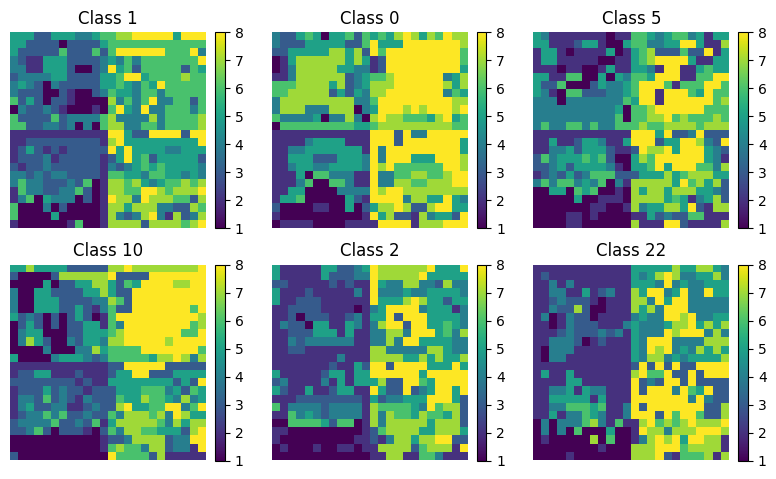

In [3]:
from dataset_utils import get_data_loader
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(8, 8*6/10))
ax_flat = ax.flatten()

for i, n_classes in enumerate([2, 4, 8, 16, 32, 64]):
    test_loader = get_data_loader('test', batch_size=64, num_classes=n_classes, shuffle=False, test_normalise=False)
    b = None
    for batch in test_loader:
        b, l = batch[0], batch[1]
        print(b.shape)
        break
    img = ax_flat[i].imshow(b[0, 0, :, :])
    ax_flat[i].set_title(f"Class {l[0]}")
    ax_flat[i].axis('off')
    plt.colorbar(img, ax=ax_flat[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("unencrypted_expert_id.pdf")

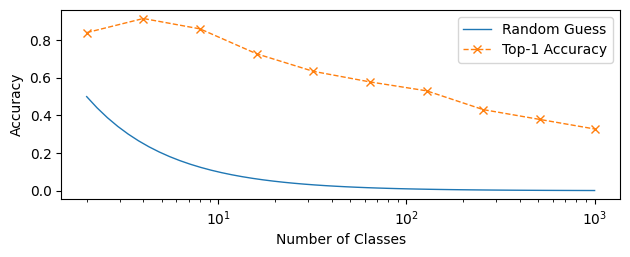

In [22]:
import matplotlib.pyplot as plt
import numpy as np

n_c_arr, perf_arr = [], []

with open("/home/zl310/cs585_project/vmoe/model_unencrypted/unencrypted_performance.txt", 'r') as f_ptr:
    lines = f_ptr.readlines()
    for line in lines:
        n_c, perf = line.split(",")
        if n_c == "num_classes":
            continue
        n_c_arr.append(int(n_c))
        perf_arr.append(float(perf))

x = np.logspace(np.log10(2), 3)
y = 1 / x
fig, ax = plt.subplots(1, 1)
ax.semilogx(x, y, linewidth=1, label='Random Guess')
ax.semilogx(n_c_arr, perf_arr, '--', marker='x', linewidth=1, label='Top-1 Accuracy')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of Classes")
ax.legend()
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("unencrypted_performance.pdf", bbox_inches='tight')